In [284]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [285]:
import pathlib
data_dir = 'BM-classification'
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1138


In [286]:
batch_size = 16
img_height = 200
img_width = 200


In [356]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Found 1138 files belonging to 2 classes.
Using 911 files for training.
Found 1138 files belonging to 2 classes.
Using 227 files for validation.


In [357]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Malignant']


In [358]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [359]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [360]:
num_classes = len(class_names)

from tensorflow.keras import regularizers

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    # Conv Block 1
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),

    # Conv Block 2
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),

    # Conv Block 3
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),

    # Regularization
    layers.Dropout(0.3),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    # Output
    layers.Dense(num_classes, name="outputs")
])


In [361]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_46 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_49 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [362]:
#Model Fitting

epochs = 45

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight={0: 1.0, 1: 1.35}
)

Epoch 1/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.5717 - loss: 1.1514 - val_accuracy: 0.7269 - val_loss: 0.7674
Epoch 2/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6611 - loss: 0.8614 - val_accuracy: 0.7533 - val_loss: 0.6487
Epoch 3/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6909 - loss: 0.8156 - val_accuracy: 0.8150 - val_loss: 0.5806
Epoch 4/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6986 - loss: 0.7942 - val_accuracy: 0.8062 - val_loss: 0.5999
Epoch 5/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7255 - loss: 0.7841 - val_accuracy: 0.8150 - val_loss: 0.5621
Epoch 6/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.7439 - loss: 0.7542 - val_accuracy: 0.7974 - val_loss: 0.5856
Epoch 7/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7574 - loss: 0.7102 - val_accuracy: 0.7841 - val_loss: 0.5890
Epoch 8/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7089 - loss: 0.7772 - val_accuracy: 0.8062 - v

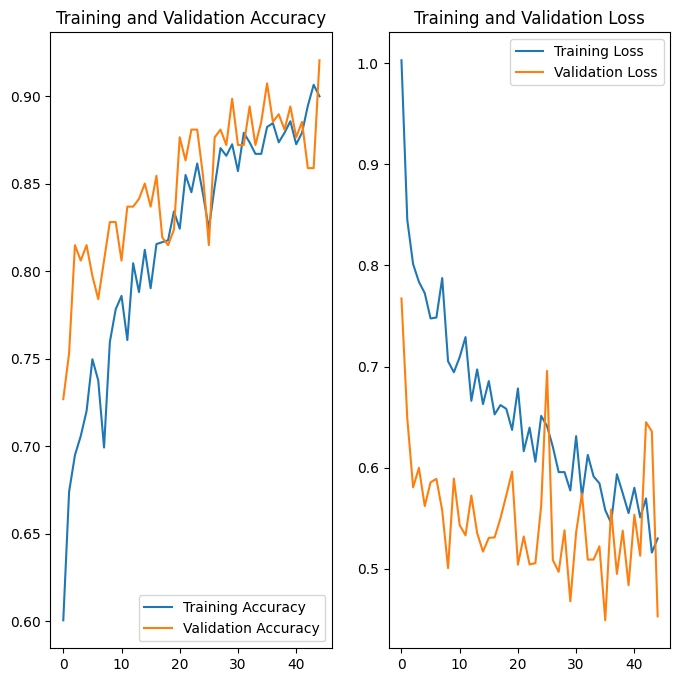

In [363]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.show()

In [ ]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred_logits = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())                          
    logits = model.predict(images, verbose=0)              
    y_pred_logits.extend(logits)

y_true = np.array(y_true).astype("int32").squeeze()
y_pred_logits = np.array(y_pred_logits)

y_pred_probs = tf.nn.softmax(y_pred_logits, axis=1).numpy()

y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape, " | unique:", np.unique(y_true))
print("y_pred shape:", y_pred.shape, " | unique:", np.unique(y_pred))

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))


y_true shape: (227,)  | unique: [0 1]
y_pred shape: (227,)  | unique: [0 1]
True Positives (TP): 95
False Positives (FP): 9
True Negatives (TN): 114
False Negatives (FN): 9

Classification Report:

              precision    recall  f1-score   support

      Benign       0.93      0.93      0.93       123
   Malignant       0.91      0.91      0.91       104

    accuracy                           0.92       227
   macro avg       0.92      0.92      0.92       227
weighted avg       0.92      0.92      0.92       227



In [370]:
model.save("BM_model.keras")

In [379]:
import random
reloaded = tf.keras.models.load_model("BM_model.keras")
#test on a random image
val_loss, val_accuracy = reloaded.evaluate(val_ds)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9204 - loss: 0.4436
Validation Loss: 0.45311239361763, Validation Accuracy: 0.9207048416137695


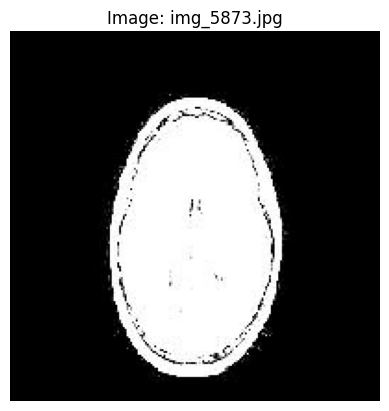

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: img_5873.jpg, Predicted Class: Benign


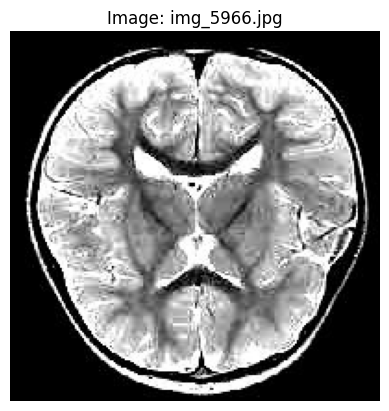

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: img_5966.jpg, Predicted Class: Benign


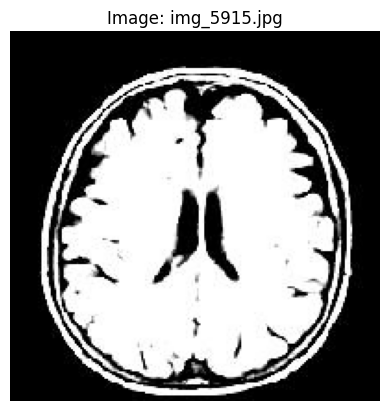

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: img_5915.jpg, Predicted Class: Benign


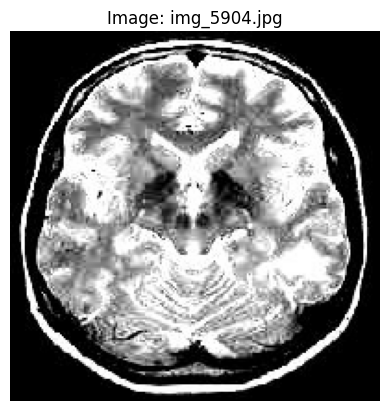

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: img_5904.jpg, Predicted Class: Benign


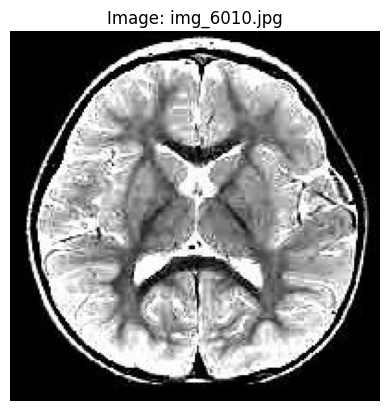

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: img_6010.jpg, Predicted Class: Benign






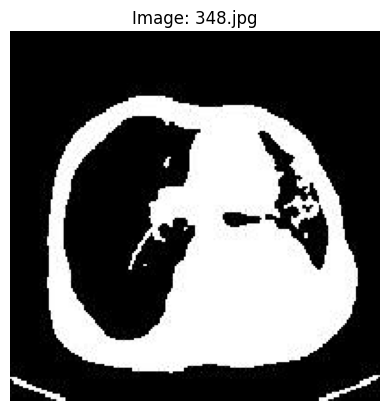

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: 348.jpg, Predicted Class: Malignant


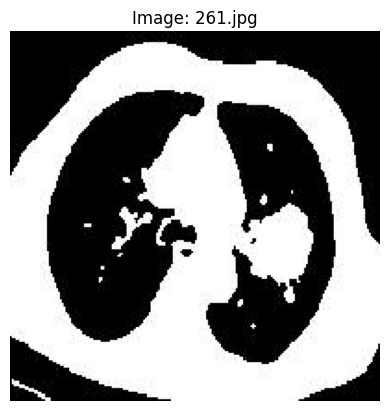

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: 261.jpg, Predicted Class: Malignant


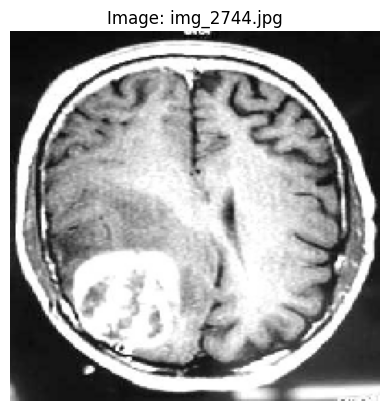

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: img_2744.jpg, Predicted Class: Malignant


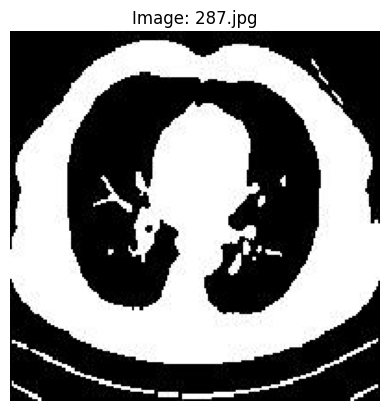

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: 287.jpg, Predicted Class: Malignant


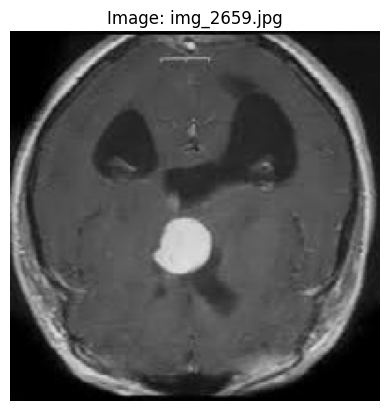

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: img_2659.jpg, Predicted Class: Malignant


In [385]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Directory containing the images
B_dir = os.path.join(data_dir, "Benign")
M_dir = os.path.join(data_dir, "Malignant")

# Get a list of all image file paths in the "yes" directory
image_paths_B = list(pathlib.Path(B_dir).glob("*.jpg"))
image_paths_M = list(pathlib.Path(M_dir).glob("*.jpg"))


test_num= 5    # Change to the desired number of random images

# Select a random subset of images
random_images_B = random.sample(image_paths_B, test_num)  
random_images_M = random.sample(image_paths_M, test_num) 

# Predict the class for each random image (BENIGN)
for image_path in random_images_B:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}")

print("\n\n\n")
# Predict the class for each random image (MALIGNANT)
for image_path in random_images_M:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}")


In [376]:

reloaded = keras.models.load_model("BM_model.keras")
reloaded.evaluate(val_ds)



15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9204 - loss: 0.4436


[0.45311239361763, 0.9207048416137695]